### ISS VSE CA2 Part2

#### By: Kenneth Goh (A0198544N), Raymond Ng (A0198543R), Tan Heng Han (A0198502B)

In [58]:
import cv2
import os
import math
import time
from collections import Counter
from itertools import repeat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob
from tqdm import tqdm

from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.optimizers import Adam

import sklearn.metrics as metrics

### Config

In [43]:
# Config
modelInWidth = 368
modelInHeight = 368
OPENPOSE_MODEL = 'coco'
TEST_SIZE = 0.2
BATCH_SIZE = 32
EPOCH = 200

### Load and slice videos for training
Slice training videos into 5hz frames for model input
Data set:
1. Push up videos
2. Mixture of non push up videos

In [44]:
# Get filenames and labels for data
labels = ['PushUps', 'NotPushUps']
data_path = 'data/'
files = pd.DataFrame()
filenames = []
for lbl in labels:
    filename = np.array(glob(os.path.join(data_path, lbl) + '/*.avi'))
    filenames.append(filename)

files['video_name'] = [item for sublist in filenames for item in sublist]
files.head()

,video_name
0,data/PushUps\v_PushUps_g01_c01.avi
1,data/NotPushUps\v_PullUps_g02_c01.avi


In [4]:
# Slice and store the frames from training videos
for i in tqdm(range(files.shape[0])):
    count = 0
    videoFile = files['video_name'][i]
    cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
    frameRate = cap.get(5) #frame rate
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        if (frameId % 2 == 0):
            # storing the frames in a new folder named train_1
            filename ='data/images/' + videoFile.split('\\')[1] +"_frame%d.jpg" % count;count+=1
            cv2.imwrite(filename, frame)
    cap.release()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.26it/s]


In [5]:
%%time
# Get filepath of all sliced images and read all images
dataset_frame_path = 'data/images'
frame_filenames = glob(dataset_frame_path + '/*.jpg')

frames_n_labels = pd.DataFrame()

frame_list = []
label_list = []
for idx in tqdm(range(len(frame_filenames))):
    frame_list.append(cv2.imread(frame_filenames[idx]))
    label = frame_filenames[idx].split('_')[1]
    if label not in labels:
        label = labels[1] # Assign all non-pushup
    label_list.append(label)
frames_n_labels['frame'] = frame_list
frames_n_labels['label'] = label_list
frames_n_labels.head()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 165.68it/s]


Wall time: 550 ms


,frame,label
0,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...",NotPushUps
1,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...",NotPushUps
2,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...",NotPushUps
3,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...",NotPushUps
4,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...",NotPushUps


Text(0.5, 1.0, 'Frame Distribution')

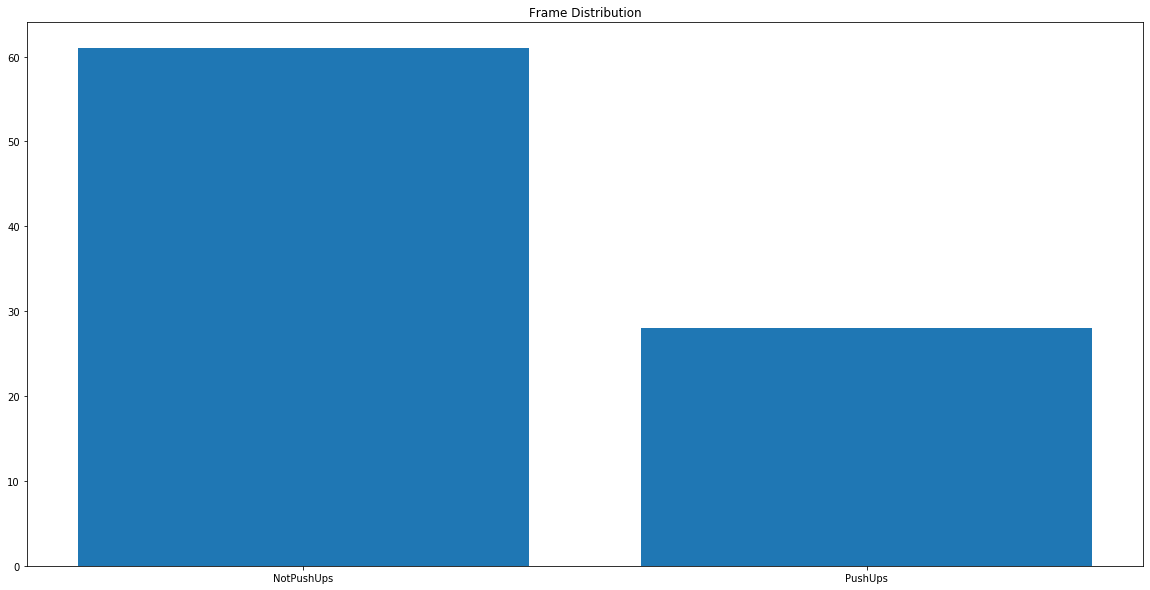

In [6]:
label_count = Counter(frames_n_labels['label'])
plt.figure(figsize=(20,10))
plt.bar(label_count.keys(), label_count.values())
plt.title('Frame Distribution')

### Load OpenPose models

#### Instructions to get openpose models
1. Clone https://github.com/CMU-Perceptual-Computing-Lab/openpose
2. Open a console and run **openpose/models/getModels.bat**
3. Copy contents from **openpose/models/pose/mpi to Model/mpi** and **openpose/models/pose/coco to Model/coco**

In [45]:
if OPENPOSE_MODEL == 'coco':
    PROTO_FILE = 'Model/coco/pose_deploy_linevec.prototxt'
    WEIGHTS_FILE = 'Model/coco/pose_iter_440000.caffemodel'
elif OPENPOSE_MODEL == 'mpi':
    PROTO_FILE = 'Model/mpi/pose_deploy_linevec_faster_4_stages.prototxt'
    WEIGHTS_FILE = 'Model/mpi/pose_iter_160000.caffemodel'
else:
    raise Exception('Open pose model not recognised, choose either mpi or coco')

In [46]:
if OPENPOSE_MODEL == 'coco':
    BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                   "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                   "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
                   "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }
    POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
                   ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
                   ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
                   ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
                   ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]
elif OPENPOSE_MODEL == 'mpi':
    BODY_PARTS = {"Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                  "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                  "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
                  "Background": 15}
    POSE_PAIRS = [ ["Head", "Neck"], ["Neck", "RShoulder"], ["RShoulder", "RElbow"],
                   ["RElbow", "RWrist"], ["Neck", "LShoulder"], ["LShoulder", "LElbow"],
                   ["LElbow", "LWrist"], ["Neck", "Chest"], ["Chest", "RHip"], ["RHip", "RKnee"],
                   ["RKnee", "RAnkle"], ["Chest", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"] ]
else:
    raise Exception('Open pose model not recognised, choose either mpi or coco')

In [47]:
# Load openpose model via Opencv
try:
    net = cv2.dnn.readNetFromCaffe(PROTO_FILE, WEIGHTS_FILE)
except:
    raise Exception('Error reading model, check model proto and weights file.')

### Run Openpose inference for each frame
Save heat maps for training

In [61]:
%%time
netout = []
for idx in tqdm(range(len(frames_n_labels['frame']))):
    currFrame = frames_n_labels['frame'][idx]
    frameWidth = currFrame.shape[1]
    frameHeight = currFrame.shape[0]
    inBlob = cv2.dnn.blobFromImage(currFrame, 1.0/255, (modelInWidth, modelInHeight), (0,0,0), swapRB=False, crop=False)
    net.setInput(inBlob)
    netout.append(np.squeeze(net.forward(), axis=0))
frames_n_labels['netout'] = netout

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 89/89 [02:52<00:00,  1.94s/it]

Wall time: 2min 52s


### Check image and pose

In [159]:
# Get random image
ridx = np.random.randint(len(frames_n_labels['netout'])-1)
testout = frames_n_labels['netout'][ridx]
testimg = frames_n_labels['frame'][ridx]

In [160]:
points = []
for i in range(len(BODY_PARTS)):
    # Slice heatmap of corresponging body's part.
    heatMap = testout[i, :, :]
 
    # Originally, we try to find all the local maximums. To simplify a sample
    # we just find a global one. However only a single pose at the same time
    # could be detected this way.
    _, conf, _, point = cv2.minMaxLoc(heatMap)
    x = (frameWidth * point[0]) / testout.shape[2]
    y = (frameHeight * point[1]) / testout.shape[1]
 
    # Add a point if it's confidence is higher than threshold.
    points.append((int(x), int(y)) if conf > 0.1 else None)

In [161]:
for pair in POSE_PAIRS:
    partFrom = pair[0]
    partTo = pair[1]
    assert(partFrom in BODY_PARTS)
    assert(partTo in BODY_PARTS)
 
    idFrom = BODY_PARTS[partFrom]
    idTo = BODY_PARTS[partTo]
    if points[idFrom] and points[idTo]:
        cv2.line(testimg, points[idFrom], points[idTo], (255, 74, 0), 3)
        cv2.ellipse(testimg, points[idFrom], (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        cv2.ellipse(testimg, points[idTo], (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        cv2.putText(testimg, str(idFrom), points[idFrom], cv2.FONT_HERSHEY_SIMPLEX, 0.35, (255, 255, 255),2,cv2.LINE_AA)
        cv2.putText(testimg, str(idTo), points[idTo], cv2.FONT_HERSHEY_SIMPLEX, 0.35, (255, 255, 255),2,cv2.LINE_AA)

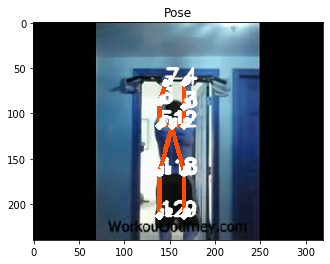

In [162]:
plt.imshow(testimg)
plt.title('Pose')
plt.show()

### Prepare training data

In [23]:
# Train test split
trainData, testData, trainLabel, testLabel = train_test_split(frames_n_labels['netout'], frames_n_labels['label'], test_size=TEST_SIZE, random_state=42)

In [24]:
print(f'trainData shape: {trainData.shape}')
print(f'testData shape: {testData.shape}')
print(f'trainLabel shape: {trainLabel.shape}')
print(f'testLabel shape: {testLabel.shape}')

trainData shape: (71,)
testData shape: (18,)
trainLabel shape: (71,)
testLabel shape: (18,)


### Training Model

In [131]:
optimizer = Adam(lr=1e-4)
base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_tensor=Input(shape=(46, 46)))

ValueError: Input 0 of layer conv1_pad is incompatible with the layer: expected ndim=4, found ndim=3. Full shape received: [None, 46, 46]

In [ ]:
def createModel():
    x = base.output
    x = AveragePooling2D(pool_size=(7,7))(x)
    x = Flatten(name='flatten')(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(len(labels), activation='softmax')(x)
    model = Model(inputs=base.input, outputs=x)
    
    for layer in base.layers:
        layer.trainable     = False
    
    model.compile(loss="categorical_crossentropy", 
                  optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [ ]:
trainModel = createModel()
inferModel = createModel()
trainModel.summary()

In [ ]:
modelname = 'pose'
modelpath = os.path.join('model_', modelname+'.hdf5')
checkpoint = ModelCheckpoint(modelpath, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')
csv_logger      = CSVLogger(modelname +'.csv')
callbacks_list  = [checkpoint,csv_logger]

In [ ]:
trainModel.fit(x=trainData, y=trainLabel,
              batch_size=BATCH_SIZE,
              validation_data=(testData,testLabel),
              epochs=EPOCH,
              callbacks=callbacks_list)

In [ ]:
inferModel.load_weights(modelpath)
inferModel.compile(loss="categorical_crossentropy", 
                  optimizer=optimizer,
                  metrics=["accuracy"])

In [ ]:
pred = inferModel.predict(testData, batch_size=BATCH_SIZE)
predout = np.argmax(pred, axis=1)
testout = np.argmax(testLabel, axis=1)

testScores = metrics.accuracy_score(testout, predout)
confusion  = metrics.confusion_matrix(testout, predout)

print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,predout,target_names=lb.classes_,digits=4))
print(confusion)